In [1]:
# --------------------------------------------------------------------------------------------
# SNOTEL observations around the Snoqualmie area for WY 2013


# Import statements
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
import scipy.io as sio
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# --------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_context('poster')
sns.set_style('whitegrid')

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Directory for the SNOTEL data
dirData = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/'
dirSNOTEL = dir_pre + 'GroundObs/SNOTEL/Washington/'
dirPrint = dir_pre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/'

## Read SNOTEL csv data

In [76]:
SNOTEL_namelist = {'Fish Lake': '478_STAND_WATERYEAR=2013.csv',
                   'Olallie Meadows': '672_STAND_WATERYEAR=2013.csv',
                   'Sasse Ridge': '734_STAND_WATERYEAR=2013.csv',
                   'Stampede Pass': '788_STAND_WATERYEAR=2013.csv',
                   'Meadows Pass': '897_STAND_WATERYEAR=2013.csv',
                   'Mount Gardner': '898_STAND_WATERYEAR=2013.csv',
                   'Tinkham Creek': '899_STAND_WATERYEAR=2013.csv',
                   'Rex River': '911_STAND_WATERYEAR=2013.csv'}

In [77]:
os.chdir(dirSNOTEL)
SNOTEL_dict = {}
for sname in SNOTEL_namelist:
    SNOTEL_dict[sname] = pd.read_csv(SNOTEL_namelist[sname],
                                     header=1,
                                     index_col='time',
                                     parse_dates={'time': ['Date','Time']},
                                     usecols=[1, 2, 3, 4, 5, 6],
                                     names=['Date', 'Time', 'SWE', 'Precip', 'Tair', 'SnowDepth'])

# Concatenate 
SNOTEL_df = pd.concat(SNOTEL_dict, axis=0, keys=SNOTEL_namelist.keys())
SNOTEL_df = pd.DataFrame(SNOTEL_df)

# Convert to xray
SNOTEL_ds = xr.Dataset.from_dataframe(SNOTEL_df)
SNOTEL_ds = SNOTEL_ds.rename({'level_0': 'station'})

# Potential to do: Drop bad Tair values
print(SNOTEL_ds)

<xarray.Dataset>
Dimensions:    (station: 8, time: 8761)
Coordinates:
  * station    (station) object 'Olallie Meadows' 'Mount Gardner' ...
  * time       (time) datetime64[ns] 2012-10-01 2012-10-01T01:00:00 ...
Data variables:
    SWE        (station, time) float64 0.0 -99.9 -99.9 -99.9 -99.9 -99.9 ...
    Precip     (station, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Tair       (station, time) float64 11.3 11.0 10.9 11.1 11.8 12.0 12.0 ...
    SnowDepth  (station, time) float64 0.0 3.0 2.0 2.0 -1.0 0.0 -1.0 1.0 0.0 ...


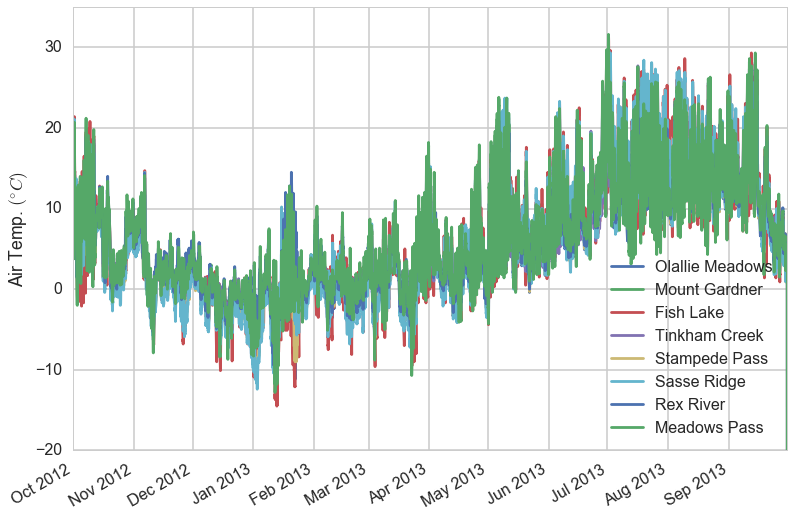

In [78]:
fig, ax = plt.subplots(1, 1)
for s in SNOTEL_ds.station:
    ax.plot(SNOTEL_ds.time, SNOTEL_ds.Tair.sel(station=s), label=s.values)
ax.set_ylim(-20, 35)
ax.set_ylabel('Air Temp. $(^{\circ} C)$')
ax.legend(loc='best')
fig.autofmt_xdate()

## SNOTEL locations

In [97]:
# Add station location
stationIndex = ['Rex River', 'Tinkham Creek',
                'Stampede Pass', 'Sasse Ridge',
                'Olallie Meadows', 'Mount Gardner',
                'Fish Lake', 'Meadows Pass']

siteMeta = {'elev': pd.Series([3810, 2990, 3850, 4340, 4030, 2920, 3430, 3230], index=stationIndex),
            'lat': pd.Series([47.3, 47.33, 47.27, 47.38, 47.37, 47.36, 47.54, 47.28], index=stationIndex),
            'lon': pd.Series([121.6, 121.46, 121.34, 121.06, 121.44, 121.57, 121.09, 121.47], index=stationIndex)}
siteMeta = pd.DataFrame(siteMeta)
siteMeta = xr.Dataset.from_dataframe(siteMeta)
siteMeta.rename({'index': 'station'}, inplace=True) 

# Merge to Dataset
SNOTEL_ds = SNOTEL_ds.merge(siteMeta)
print(SNOTEL_ds)

<xarray.Dataset>
Dimensions:    (station: 8, time: 8761)
Coordinates:
  * station    (station) object 'Fish Lake' 'Meadows Pass' 'Mount Gardner' ...
  * time       (time) datetime64[ns] 2012-10-01 2012-10-01T01:00:00 ...
Data variables:
    SWE        (station, time) float64 0.0 -0.4 -0.4 -0.3 -0.4 -0.3 -0.4 ...
    Precip     (station, time) float64 0.0 0.0 -0.1 -0.1 0.0 -0.1 -0.1 -0.1 ...
    Tair       (station, time) float64 8.2 7.7 7.4 7.4 7.4 7.7 8.2 10.9 12.4 ...
    SnowDepth  (station, time) float64 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    elev       (station) int64 3430 3230 2920 4030 3810 4340 3850 2990
    lat        (station) float64 47.54 47.28 47.36 47.37 47.3 47.38 47.27 47.33
    lon        (station) float64 121.1 121.5 121.6 121.4 121.6 121.1 121.3 121.5


In [98]:
os.chdir(dirData)
SNOTEL_ds.to_netcdf('WA_SNOTEL.WY2013.nc')